In [1]:
from ensembles import VanillaEnsemble, BootstrapEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 4]
from evaluation import evaluate_model
import tensorflow as tf

# Explanation



Showing the efficiency of two types of ensembles, Vanilla Network Ensemble with different initialisation parameters and Bootstrap Ensemble grown by presenting copies of the exact same model with different subsets of the dataset.

All underlying Estimators are built in tensorflow (1.4) and are based on the same parent object (ToDo: Make this more beautiful and readable). Can be found in /estimators. The Ensembles simulate Online Training rather than actually training online at the moment (ToDo: Rewrite Ensembles to train online properly). The Code can be found in /ensembles.

VanillaEnsemble, which is an ensemble of the class EnsembleNetwork that differ in two significant ways: 
    1. different number of layers 
    2. different initial conditions (translates to different seeds at weight initialisation time)
    3. each of the networks are shown the full dataset
Inspired by an approach used in [1]

    
   
BootstrapEnsemble, which is an ensemble of the class EnsembleNetwork in which each part of the ensemble:
    1. share the exact same hyperparameters
    2. share the same initial conditions (translates to setting the same seed at weight initialisation time)
    3. are each shown  ~ 50% of the Dataset
Expansion of [2] to (kind of) work with Deep Networks 


No Regularisation has been added, thus quite a bit of overfitting occurs.

ToDo:

- add Dropout Ensemble from [3]





# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), for the Bootstrap network a distribution over parameters can be achieved by assuming that each $w_i$ is a draw from a normal distribution. While thinkable in theory, the same is non-trivial for an ensemble with differing hyperparameters (i.e. different number of layers and different layer sizes).

# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is offline. The datasets are shown to the estimators as a whole (although it should be relatively easy to switch to online) (ToDo: Switch to Online). The Bootstrap in the Bootstrap Estimator is achieved by randomly drawing  sub-datasets that each contain ~ 50% of datapoints.
The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list) (ToDo: solve that)

# Problems/ToDo

It's not entirely clear (ToDo: Literature search) what scaling factor should be used for the variance. While the VanillaEnsemble can to a certain extend be influenced by choosing vastly different models (including untouched hyperparameters such as but not limited to _weight initialisation schemes, optimisation algorithms, learning rate,..._, it's not entirely obvious which hyperparameters apart from the number of estimators $p_{keep}$ that regulates the size of the subsampled datasets can be chosen to generate inherently greater (or lower) variance in the samples.

Hyperparameters need to be tuned

No real Online Training

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)




[1] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474



[2] Eckles, D., & Kaptein, M. (2014). Thompson sampling with the online bootstrap. arXiv preprint arXiv:1410.4009.

Link: https://arxiv.org/abs/1410.4009


[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

# Preparations

In [2]:
seed = 43
data = make_dataset(train_p=0.8,seed=seed)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

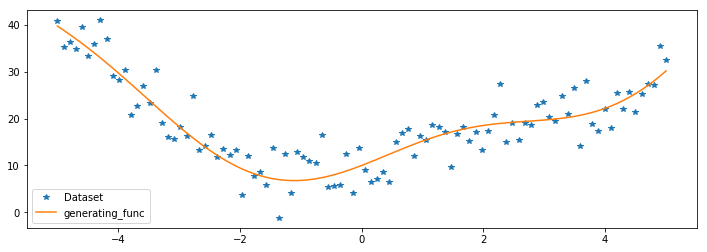

In [3]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Initialise Ensembles

In [4]:
num_epochs = 10
num_eps = 25#100
#ensemble = [{'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
#            {'num_neurons':[10,10,10,10,10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        

ensemble = [{'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,5,20],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,10,10],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10,5],'num_epochs':num_epochs},#,'optimizer':tf.train.AdamOptimizer},
            {'num_neurons':[10,10],'num_epochs':num_epochs}]#,'optimizer':tf.train.AdamOptimizer}]
        
    
    
vanilla = VanillaEnsemble(estimator_stats = ensemble)


#bootstrap_ensemble = {'num_neurons':[10,10,10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}
bootstrap_ensemble = {'num_neurons':[10,10,10],'num_epochs':num_epochs}#,'optimizer':tf.train.AdamOptimizer}

bootstrap = BootstrapEnsemble(estimator_stats= bootstrap_ensemble)

In [5]:
def get_mean_var(pred_dict):
    return pred_dict['means'],pred_dict['stds']
    

Vanilla Ensemble already displays a measure of uncertainty due to the ensembled models being initialised differently.
Bootstrap Ensemble does not have uncertainty die to the fact that all contained models are initialised in exactly the same way (thus each sample returns the exact same values)

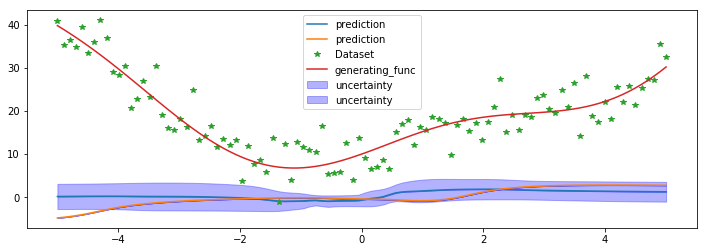

In [6]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var)

plot_prediction(X,
                bootstrap_preds,
                sorted_index,
                bootstrap_var)

plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Training

## Vanilla Ensemble

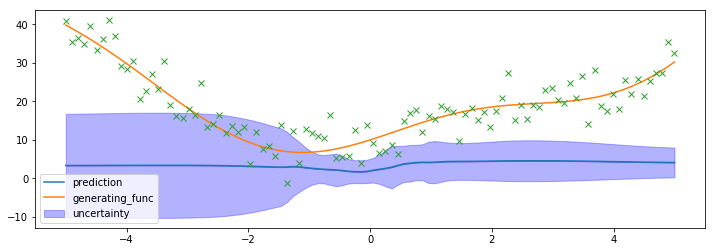

RSME is 17.5233211517334
COVERAGE PROBABILITY is 0.21
MEAN VARIANCE is 7.715137958526611
COVERAGE/MEAN_VAR is 0.027219215149343157


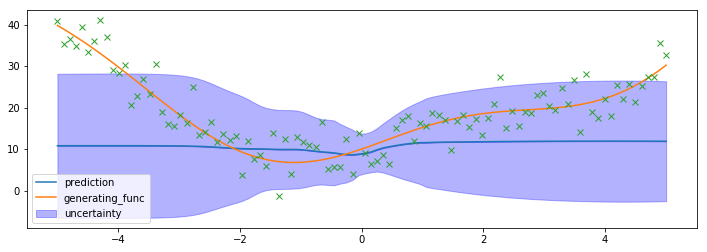

RSME is 11.732229232788086
COVERAGE PROBABILITY is 0.79
MEAN VARIANCE is 12.935094833374023
COVERAGE/MEAN_VAR is 0.061074156021006486


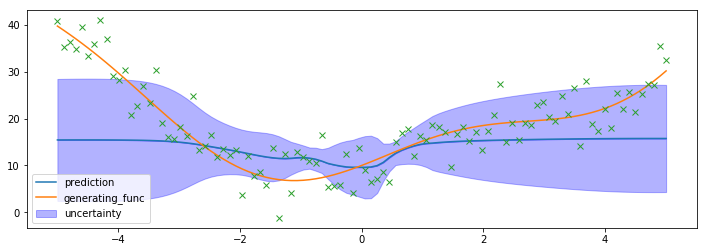

RSME is 9.129034042358398
COVERAGE PROBABILITY is 0.7
MEAN VARIANCE is 8.390193939208984
COVERAGE/MEAN_VAR is 0.08343072938144681


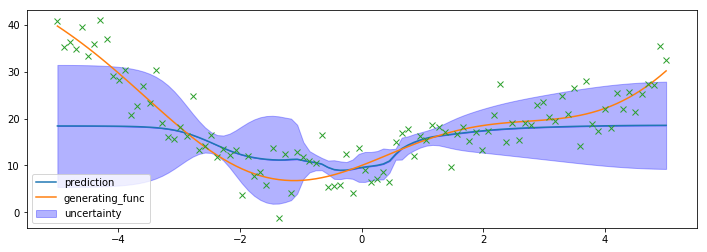

RSME is 7.626771450042725
COVERAGE PROBABILITY is 0.66
MEAN VARIANCE is 6.679973125457764
COVERAGE/MEAN_VAR is 0.09880279270656073


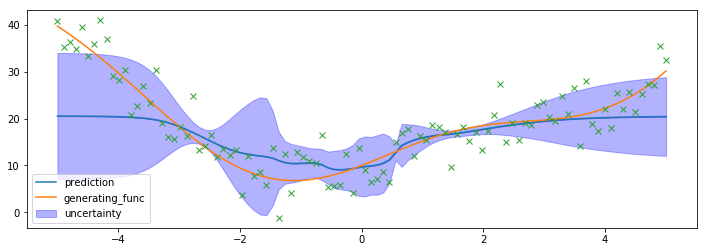

RSME is 6.7875285148620605
COVERAGE PROBABILITY is 0.67
MEAN VARIANCE is 6.2006449699401855
COVERAGE/MEAN_VAR is 0.10805327562665842


In [7]:
vanilla_error_list = []
for i in range(num_eps):
    vanilla.train(X,y)
    #errors = vanilla.train_and_evaluate(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #vanilla_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        vanilla_pred_dict = vanilla.predict(X)
        vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
        vanilla_var = vanilla_var**2
        plot_prediction(X,vanilla_preds,sorted_index,vanilla_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds,var=vanilla_var)

In [8]:
#plt.plot(np.squeeze(vanilla_error_list))

## Bootstrap Ensemble

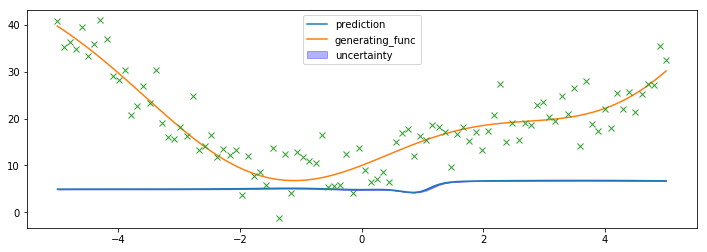

RSME is 15.931488037109375
COVERAGE PROBABILITY is 0.0
MEAN VARIANCE is 0.05661753565073013
COVERAGE/MEAN_VAR is 0.0


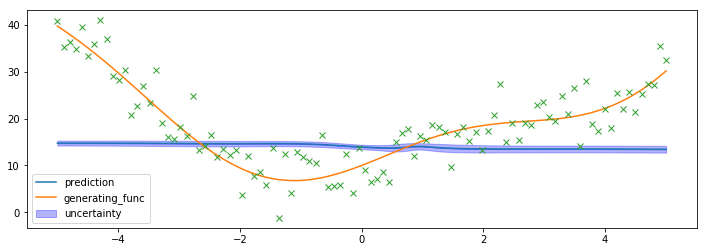

RSME is 10.227437973022461
COVERAGE PROBABILITY is 0.04
MEAN VARIANCE is 0.6402997374534607
COVERAGE/MEAN_VAR is 0.06247074246677689


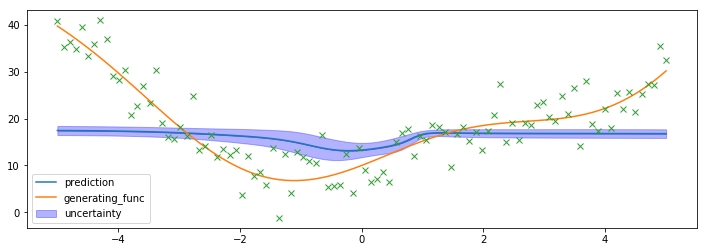

RSME is 8.717998504638672
COVERAGE PROBABILITY is 0.13
MEAN VARIANCE is 1.2014763355255127
COVERAGE/MEAN_VAR is 0.1082002168133752


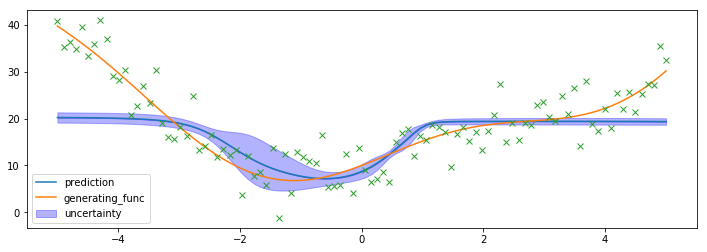

RSME is 7.072462558746338
COVERAGE PROBABILITY is 0.18
MEAN VARIANCE is 1.3861346244812012
COVERAGE/MEAN_VAR is 0.1298575165939383


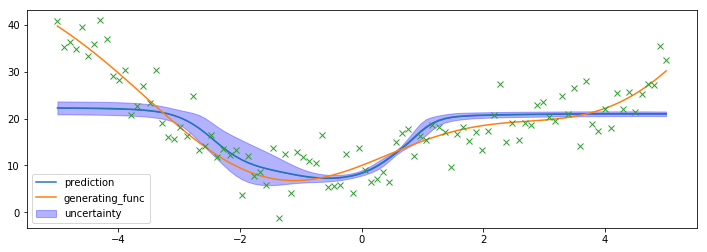

RSME is 6.370020389556885
COVERAGE PROBABILITY is 0.19
MEAN VARIANCE is 1.3135626316070557
COVERAGE/MEAN_VAR is 0.14464479685110085


In [9]:
gauss_error_list = []
for i in range(num_eps):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2
        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

# Old Stuff, can probably be deleted, kept for security reasons

In [10]:
vanilla.train(X,y)
bootstrap.train(X,y)

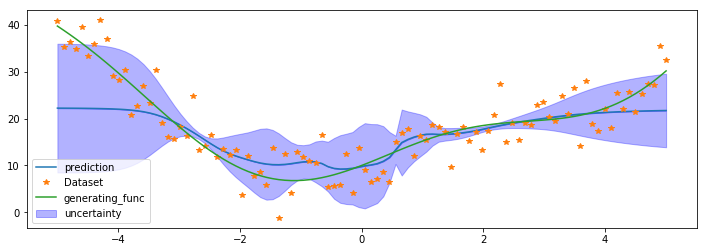

In [11]:
vanilla_pred_dict = vanilla.predict(X)
vanilla_preds, vanilla_var = get_mean_var(vanilla_pred_dict)
bootstrap_pred_dict = bootstrap.predict(X)
bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_dict)
plot_prediction(X,
                vanilla_preds,
                sorted_index,
                vanilla_var**2)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

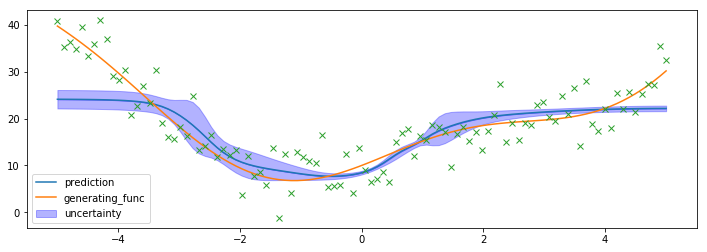

RSME is 5.750490188598633
COVERAGE PROBABILITY is 0.23
MEAN VARIANCE is 1.5627245903015137
COVERAGE/MEAN_VAR is 0.14717884483767135


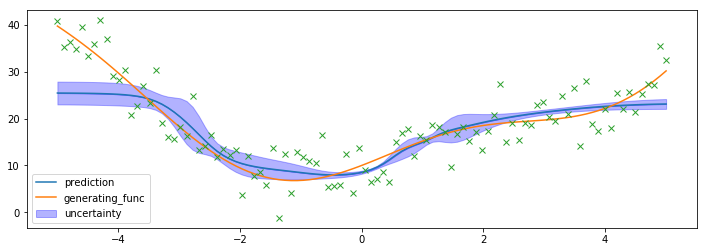

RSME is 5.350194454193115
COVERAGE PROBABILITY is 0.2
MEAN VARIANCE is 1.5906826257705688
COVERAGE/MEAN_VAR is 0.12573218362972607


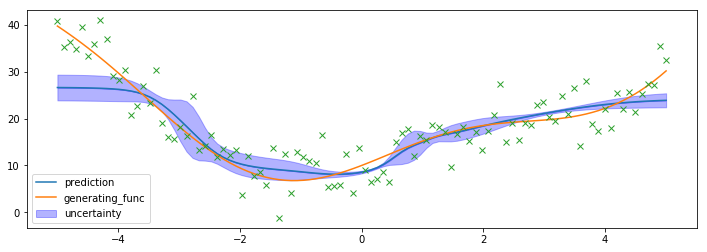

RSME is 5.038471698760986
COVERAGE PROBABILITY is 0.21
MEAN VARIANCE is 1.6980570554733276
COVERAGE/MEAN_VAR is 0.12367075612866447


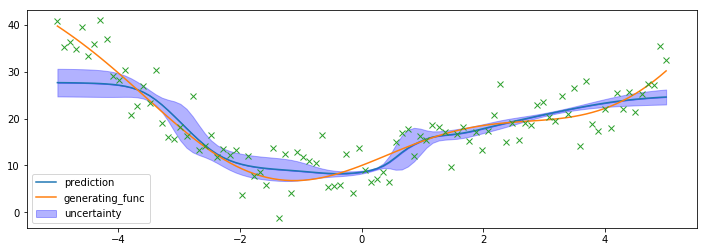

RSME is 4.798476696014404
COVERAGE PROBABILITY is 0.22
MEAN VARIANCE is 1.6263459920883179
COVERAGE/MEAN_VAR is 0.13527256873398008


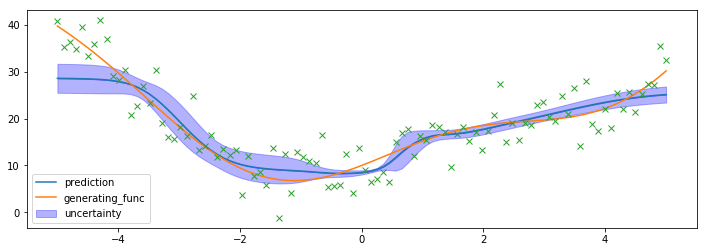

RSME is 4.621253967285156
COVERAGE PROBABILITY is 0.27
MEAN VARIANCE is 1.9699249267578125
COVERAGE/MEAN_VAR is 0.13706106071990148


In [12]:
#gauss_error_list = []
for i in range(num_eps):
    bootstrap.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = bootstrap.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [13]:
evaluate_model(X,y,vanilla_preds,var=vanilla_var**2)

RSME is 6.1654205322265625
COVERAGE PROBABILITY is 0.65
MEAN VARIANCE is 5.7302327156066895
COVERAGE/MEAN_VAR is 0.11343343844128347


In [14]:
evaluate_model(X,y,bootstrap_preds,var=bootstrap_var**2)

RSME is 4.621253967285156
COVERAGE PROBABILITY is 0.57
MEAN VARIANCE is 4.793600559234619
COVERAGE/MEAN_VAR is 0.11890853085410401


# Hic sunt dracones

In [15]:
from ensembles import GaussianNetworkEnsemble, GaussianLRNetworkEnsemble


In [16]:
gauss = GaussianNetworkEnsemble(estimator_stats = ensemble)

In [17]:
gauss_dict = gauss.predict(X)

In [18]:
mean,std = get_mean_var(gauss_dict)

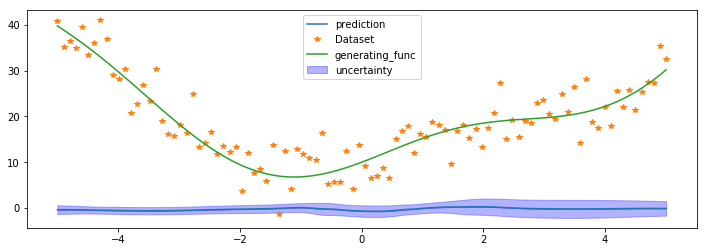

In [19]:
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

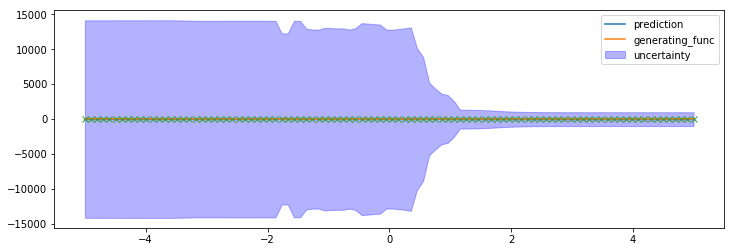

RSME is 32.21537780761719
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 8193.681640625
COVERAGE/MEAN_VAR is 0.00012204525924486879


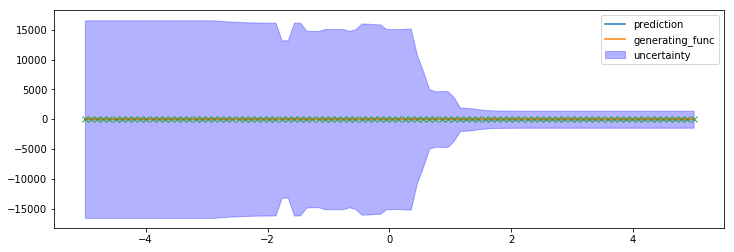

RSME is 25.356367111206055
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 9593.474609375
COVERAGE/MEAN_VAR is 0.00010423751984737347


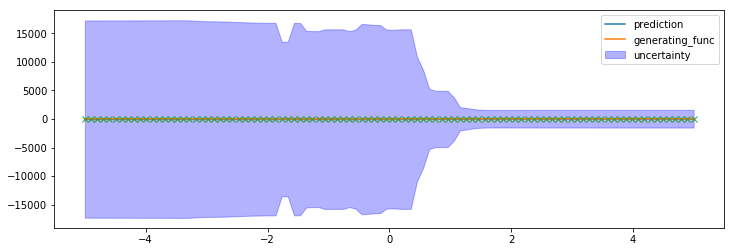

RSME is 34.63765335083008
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 9999.845703125
COVERAGE/MEAN_VAR is 0.00010000154299255789


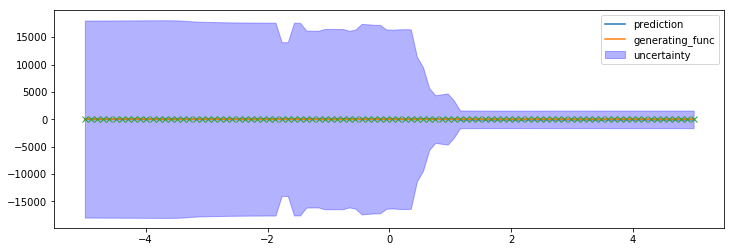

RSME is 30.10740089416504
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 10393.544921875
COVERAGE/MEAN_VAR is 9.621356404544212e-05


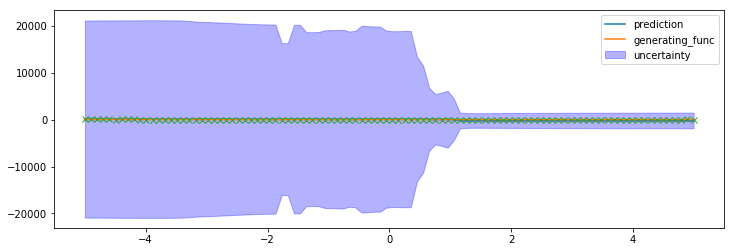

RSME is 144.68130493164062
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 11978.857421875
COVERAGE/MEAN_VAR is 8.348041593465048e-05


In [20]:
#gauss_error_list = []
for i in range(num_eps):
    gauss.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [21]:
gauss.train(X,y)

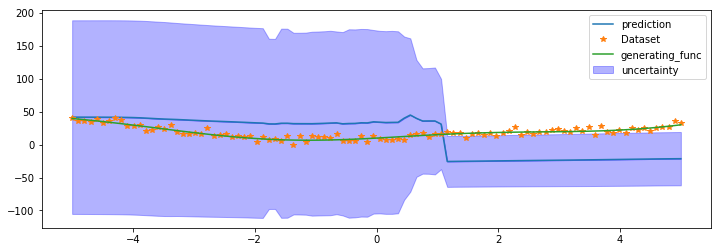

In [22]:
gauss_dict = gauss.predict(X)
mean,std = get_mean_var(gauss_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# Learning Rate stuff


In [23]:
gauss_lr = GaussianLRNetworkEnsemble(estimator_stats = ensemble)

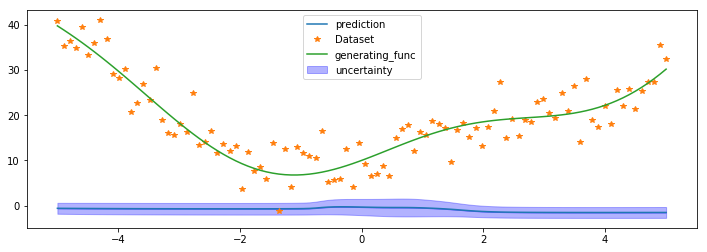

In [24]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

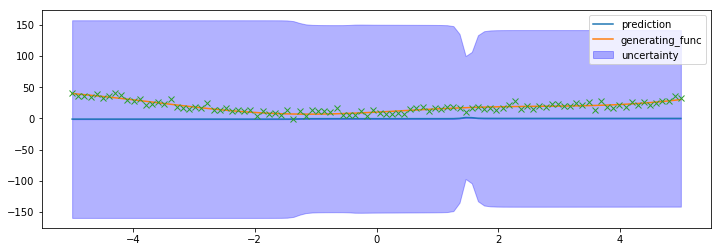

RSME is 21.376304626464844
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 149.28941345214844
COVERAGE/MEAN_VAR is 0.00669839861297686


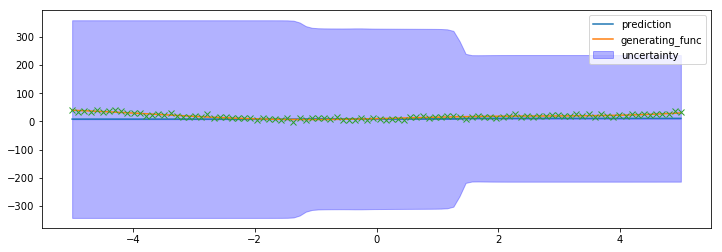

RSME is 12.918305397033691
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 296.4573059082031
COVERAGE/MEAN_VAR is 0.0033731669959574085


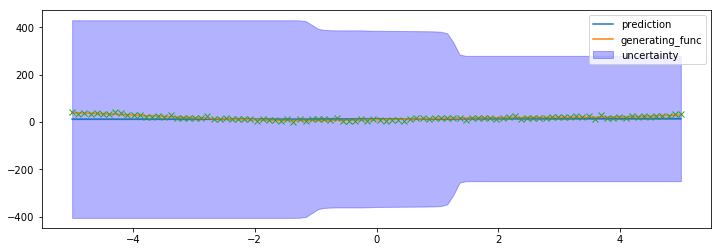

RSME is 10.375974655151367
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 349.8597412109375
COVERAGE/MEAN_VAR is 0.0028582882858679067


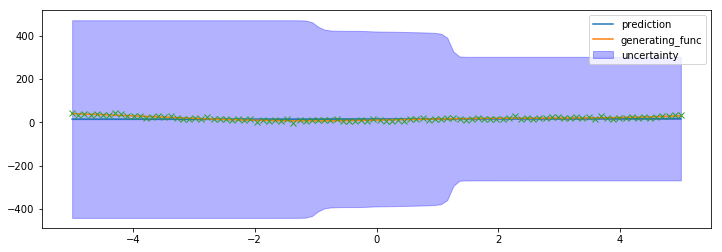

RSME is 9.537676811218262
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 380.3282470703125
COVERAGE/MEAN_VAR is 0.0026293077301069536


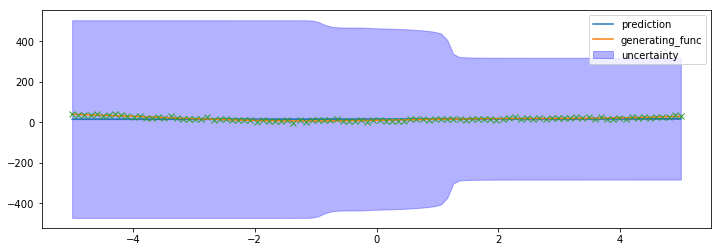

RSME is 9.222643852233887
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 407.31500244140625
COVERAGE/MEAN_VAR is 0.0024551023016733927


In [25]:
#gauss_error_list = []
for i in range(num_eps):
    gauss_lr.train(X,y)
    #errors = gauss.train_and_evaluate(X,y)
    #gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        bootstrap_pred_list = gauss_lr.predict(X)
        bootstrap_preds, bootstrap_var = get_mean_var(bootstrap_pred_list)
        bootstrap_var = bootstrap_var**2

        plot_prediction(X,bootstrap_preds,sorted_index,bootstrap_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,bootstrap_preds,var=bootstrap_var)

In [26]:
gauss_lr.train(X,y)

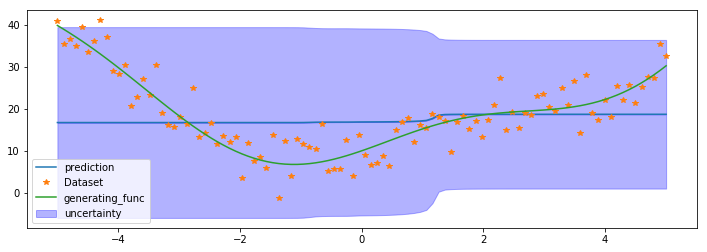

In [27]:
gauss_lr_dict = gauss_lr.predict(X)
mean,std = get_mean_var(gauss_lr_dict)
plot_prediction(X,
                mean,
                sorted_index,
                std)
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)